In [31]:
import pandas as pd
import numpy as np

daily = pd.read_csv("../data/clean_pm25.csv", parse_dates=["datetime"], index_col="datetime")
df_all = daily.reset_index().rename(columns={"datetime": "ds", "pm25": "y"})
H = 60
df_train = df_all.iloc[:-H].copy()
df_test  = df_all.iloc[-H:].copy()

df_train.head(), df_test.shape


(          ds           y
 0 2010-01-01  129.000000
 1 2010-01-02  144.333333
 2 2010-01-03   78.375000
 3 2010-01-04   29.291667
 4 2010-01-05   43.541667,
 (60, 2))

In [32]:
import sys, pkgutil, importlib, inspect

# 1) Where is "prophet" coming from?
import prophet
print("prophet version:", getattr(prophet, "__version__", "unknown"))
print("prophet module path:", prophet.__file__)

# 2) What is Prophet?
from prophet import Prophet
print("Prophet object:", Prophet)

# 3) Sanity: try constructing a bare model (should NOT error)
try:
    _m = Prophet()
    print("Prophet() constructed OK.")
except Exception as e:
    print("Prophet() construction failed:", repr(e))


prophet version: 1.1.5
prophet module path: c:\Users\sergi_nyo0upt\OneDrive\Documents\Projects\pollution-forecasting\.venv\Lib\site-packages\prophet\__init__.py
Prophet object: <class 'prophet.forecaster.Prophet'>
Prophet() constructed OK.


In [33]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean()) * 100

m_base = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.2,
)
m_base.fit(df_train[["ds","y"]])

fcst_test = m_base.predict(df_test[["ds"]])
pred = fcst_test["yhat"].to_numpy()

metrics_prophet = {
    "MAE":  mean_absolute_error(df_test["y"], pred),
    "RMSE": mean_squared_error(df_test["y"], pred, squared=False),
    "MAPE": mape(df_test["y"], pred),
}
metrics_prophet


00:06:24 - cmdstanpy - INFO - Chain [1] start processing
00:06:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\sergi_nyo0upt\OneDrive\Documents\Projects\pollution-forecasting\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': 106.7366186087261,
 'RMSE': 145.78997041639218,
 'MAPE': 126.69714312482725}

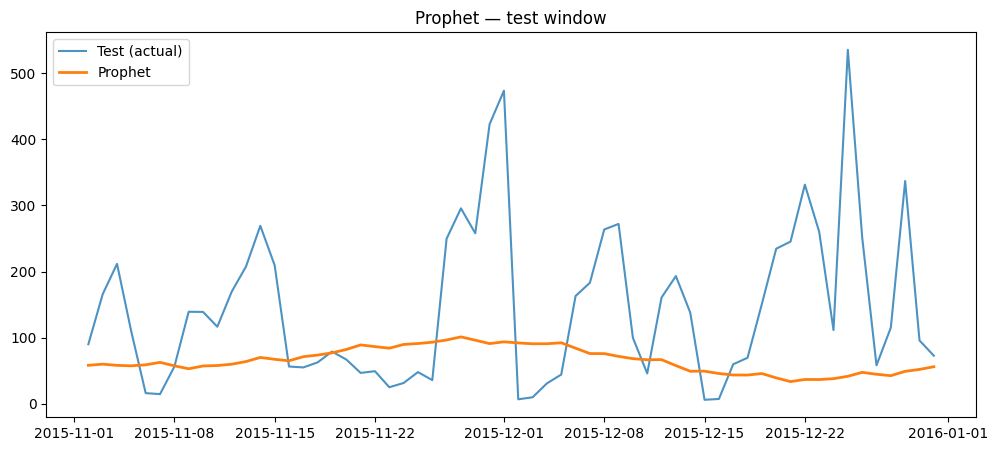

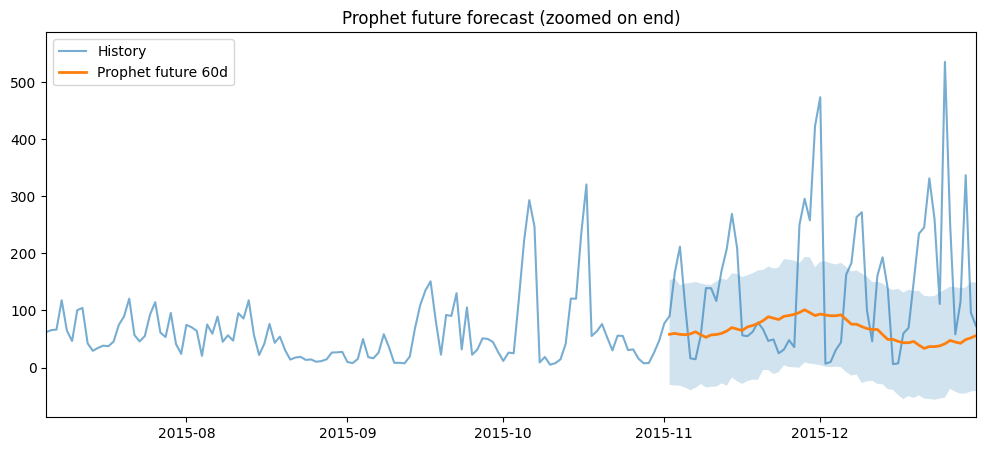

,yhat,yhat_lower,yhat_upper
ds,,,
2015-11-02,58.233856,-30.181981,152.925206
2015-11-03,59.994961,-31.481080,156.345763
2015-11-04,58.148047,-31.554441,144.061674
2015-11-05,57.517478,-35.239496,147.077185
2015-11-06,59.006910,-39.673436,148.050449


In [34]:
import matplotlib.pyplot as plt

# Test window plot
plt.figure(figsize=(12,5))
plt.plot(df_test["ds"], df_test["y"], label="Test (actual)", alpha=0.8)
plt.plot(df_test["ds"], pred, label="Prophet", linewidth=2)
plt.title("Prophet — test window")
plt.legend(); plt.show()

# Future forecast H days ahead
future_all = m_base.make_future_dataframe(periods=H, freq="D")
fcst_all = m_base.predict(future_all)
future = fcst_all.tail(H).set_index("ds")[["yhat","yhat_lower","yhat_upper"]]

plt.figure(figsize=(12,5))
plt.plot(df_all["ds"], df_all["y"], label="History", alpha=0.6)
plt.plot(future.index, future["yhat"], label=f"Prophet future {H}d", linewidth=2)
plt.fill_between(future.index, future["yhat_lower"], future["yhat_upper"], alpha=0.2)
plt.xlim(df_all["ds"].iloc[-180], future.index[-1])
plt.title("Prophet future forecast (zoomed on end)")
plt.legend(); plt.show()

# Save for the app
future[["yhat"]].rename(columns={"yhat":"forecast"}).to_csv("../data/forecast_prophet.csv")
future.head()


00:06:26 - cmdstanpy - INFO - Chain [1] start processing
00:06:26 - cmdstanpy - INFO - Chain [1] done processing


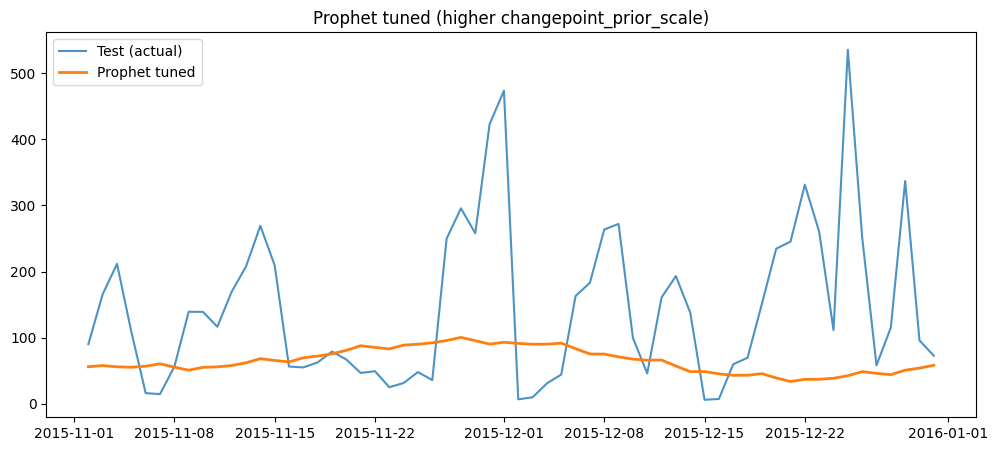

In [35]:
# More flexible Prophet (captures sudden trend shifts)
m_tuned = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.8,  # ↑ was 0.2, allows faster changes
)

m_tuned.fit(df_train[["ds", "y"]])
fcst_tuned = m_tuned.predict(df_test[["ds"]])

# Plot comparison
plt.figure(figsize=(12,5))
plt.plot(df_test["ds"], df_test["y"], label="Test (actual)", alpha=0.8)
plt.plot(df_test["ds"], fcst_tuned["yhat"], label="Prophet tuned", linewidth=2)
plt.title("Prophet tuned (higher changepoint_prior_scale)")
plt.legend(); plt.show()


00:06:27 - cmdstanpy - INFO - Chain [1] start processing
00:06:28 - cmdstanpy - INFO - Chain [1] done processing


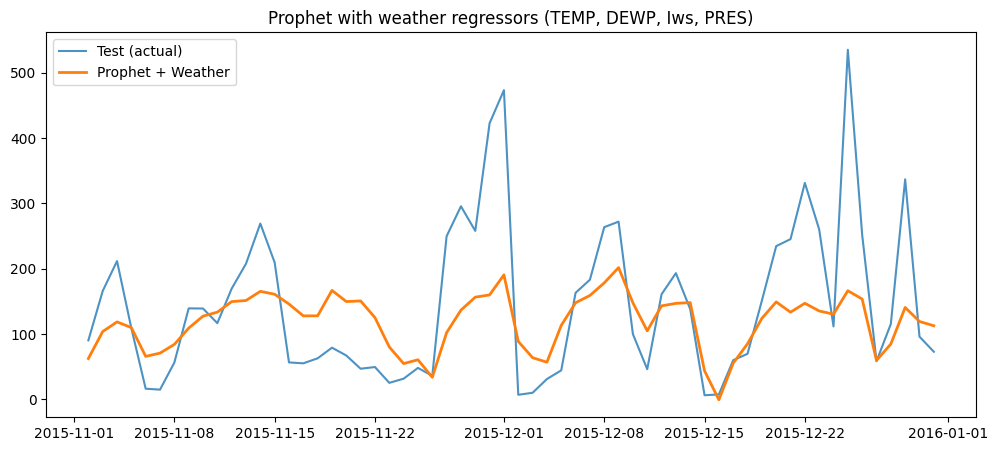

In [36]:
# Load weather data from the original CSV
weather = pd.read_csv("../data/BeijingPM20100101_20151231.csv", na_values=["NA"])
weather["datetime"] = pd.to_datetime(dict(year=weather["year"], month=weather["month"], day=weather["day"], hour=weather["hour"]))
weather = weather.set_index("datetime").sort_index()

# Daily averages of weather variables
daily_weather = weather.resample("D")[["TEMP", "DEWP", "Iws", "PRES"]].mean().ffill().bfill()

# Merge with target
df_merged = df_all.set_index("ds").join(daily_weather, how="left").reset_index()

# Re-split
df_train_exo = df_merged.iloc[:-H]
df_test_exo = df_merged.iloc[-H:]

# Create model with regressors
m_reg = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.6
)

for reg in ["TEMP", "DEWP", "Iws", "PRES"]:
    m_reg.add_regressor(reg)

# Fit
m_reg.fit(df_train_exo[["ds", "y", "TEMP", "DEWP", "Iws", "PRES"]])

# Predict
fcst_reg = m_reg.predict(df_test_exo[["ds", "TEMP", "DEWP", "Iws", "PRES"]])

# Plot
plt.figure(figsize=(12,5))
plt.plot(df_test["ds"], df_test["y"], label="Test (actual)", alpha=0.8)
plt.plot(df_test["ds"], fcst_reg["yhat"], label="Prophet + Weather", linewidth=2)
plt.title("Prophet with weather regressors (TEMP, DEWP, Iws, PRES)")
plt.legend(); plt.show()


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(y_true, y_pred, name):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0          # avoid divide-by-zero
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    print(f"{name}:\n  MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%\n")
    return mae, rmse, mape


evaluate_model(df_test["y"], pred, "Prophet (Base)")
evaluate_model(df_test["y"], fcst_tuned["yhat"], "Prophet (Tuned)")
evaluate_model(df_test["y"], fcst_reg["yhat"], "Prophet + Weather")


Prophet (Base):
  MAE=106.74, RMSE=145.79, MAPE=126.70%

Prophet (Tuned):
  MAE=106.74, RMSE=145.96, MAPE=125.32%

Prophet + Weather:
  MAE=70.19, RMSE=99.38, MAPE=101.93%



c:\Users\sergi_nyo0upt\OneDrive\Documents\Projects\pollution-forecasting\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\sergi_nyo0upt\OneDrive\Documents\Projects\pollution-forecasting\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\sergi_nyo0upt\OneDrive\Documents\Projects\pollution-forecasting\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(70.19047194495121, 99.38289707121358, 101.93145157062237)